In [124]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [87]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler as sc
digits = load_digits()

In [88]:
print(digits.images.shape)

(1797, 8, 8)


<Figure size 432x288 with 0 Axes>

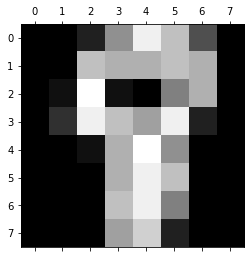

8


In [89]:
import pylab as pl
pl.gray()
pl.matshow(digits.images[1542])
pl.show()
print(digits.target[1542])

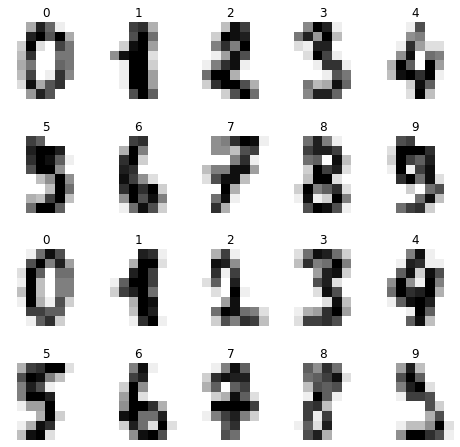

In [90]:
images_and_labels=list(zip(digits.images,digits.target))
plt.figure(figsize=(8,8))
for index,(image,label) in enumerate(images_and_labels[:20]):
    plt.subplot(4,5,index+1)
    plt.axis('off')
    plt.imshow(image,cmap=plt.cm.gray_r,interpolation='nearest')
    plt.title(label)

In [91]:
m = digits.images.shape[0]
print(m)

x = digits.images.reshape(m,-1)
print(x.shape)

1797
(1797, 64)


In [92]:
y = digits.target
y = y.reshape(-1,1)
print(y.shape)

(1797, 1)


In [93]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0)

In [94]:
print(X_train.shape)
print(y_train.shape)

(1437, 64)
(1437, 1)


In [95]:
#Standardising data
#sc is StandardScaler : This simply standardises data by x = (x-u)/s
#where u is mean and s is standard deviation
X_train = sc().fit_transform(X_train)
X_test = sc().fit_transform(X_test)

In [96]:
#Taking transpose of X_train,X_test,Y_train,Y_test

X_train = X_train.T
y_train = y_train.T
X_test = X_test.T
y_test = y_test.T

print(X_train.shape)

(64, 1437)


In [97]:
#Making a matrix Y_train_ of size(10,m) from y_train of size(1,m)
#so that the result can have 10 nodes each represnting values
#from 0 to 9

#m represents no. of training examples
m = y_train.shape[1]
Y_train_ = np.zeros((10,m))

for i in range(m):
    Y_train_[y_train[0][i],i] = 1

Y_test_ = np.zeros((10,y_test.shape[1]))

for i in range(y_test.shape[1]):
    Y_test_[y_test[0][i],i] = 1

In [98]:
# sigmoid, its derivative and inverse functions
def sigmoid_(Z):
    return 1/(1+np.exp(-Z))

def sigmoid(Z):
    return sigmoid_(Z),Z

def dsigmoid_(Z):
    return sigmoid_(Z)*(1-sigmoid_(Z))

def sigmoid_backward(dA,activation_cache):
    return dA* dsigmoid_(activation_cache)

In [99]:
#Relu, its derivative and inverse functions
def relu_(Z):
    return Z*(Z>0)

def relu(Z):
    return relu_(Z),Z

def drelu_(Z):
    return 1*(Z>0)

def relu_backward(dA,activation_cache):
    return dA* drelu_(activation_cache)

In [100]:
# initialize parameters for deep neural networks
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) 
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1])*0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l],1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))
    return parameters

In [101]:
def linear_forward(A, W, b):
    Z = np.dot(W,A)+b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [102]:
def linear_activation_forward(A_prev,W,b,activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = sigmoid(Z)
        
    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev,W,b)
        A, activation_cache = relu(Z)

    cache = (linear_cache, activation_cache)
    
    return A, cache

In [103]:
# implementation of forward propogation for L layer neural network
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2   
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev,parameters['W'+str(l)],parameters['b'+str(l)],"relu")
        caches.append(cache)
    AL, cache = linear_activation_forward(A,parameters['W'+str(L)],parameters['b'+str(L)],"sigmoid")
    
    caches.append(cache)

    return AL, caches

In [104]:
def compute_cost(AL, Y):
    m=Y.shape[1]
    cost = -(1/m)*np.sum((Y*np.log(AL)+(1-Y)*np.log(1-AL)))
    cost=np.squeeze(cost)

    return cost

In [105]:
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = np.dot(dZ,A_prev.T)/m
    db = np.sum(dZ,axis=1,keepdims=True)/m
    dA_prev = np.dot(W.T,dZ)
    
    return dA_prev, dW, db

In [106]:
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    if activation == "relu":
        dZ = relu_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA,activation_cache)
        dA_prev, dW, db = linear_backward(dZ,linear_cache)
    
    return dA_prev,dW,db

In [107]:
#Back propogation for L layers
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    #Y = Y.reshape(AL.shape)
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL,current_cache,"sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA"+str(l+1)],current_cache,"relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
    
    return grads

In [108]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)]-(learning_rate)*grads["dW"+str(l+1)] 
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)]-(learning_rate)*grads["db"+str(l+1)]
    
    return parameters

In [109]:
# N layer neural network
n_x=64
layers_dims=[n_x,60,10,10]

def L_layer_model(X, Y, layers_dims, learning_rate = 0.005, num_iterations = 3000, print_cost=False):
    np.random.seed(1)
    costs = [] 
    
    parameters = initialize_parameters_deep(layers_dims)
    
    for i in range(0, num_iterations):
        AL, caches = L_model_forward(X, parameters)
        cost = compute_cost(AL, Y)
        grads = L_model_backward(AL, Y, caches)
        parameters = update_parameters(parameters, grads, learning_rate)
        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    #plotting the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 6.931433
Cost after iteration 1000: 3.774829
Cost after iteration 2000: 3.262610
Cost after iteration 3000: 3.249175
Cost after iteration 4000: 3.248149
Cost after iteration 5000: 3.245551
Cost after iteration 6000: 3.234484
Cost after iteration 7000: 3.108940
Cost after iteration 8000: 2.714129
Cost after iteration 9000: 2.217460
Cost after iteration 10000: 1.924373
Cost after iteration 11000: 1.561357
Cost after iteration 12000: 1.231272
Cost after iteration 13000: 0.951040
Cost after iteration 14000: 0.764662
Cost after iteration 15000: 0.618042
Cost after iteration 16000: 0.489283
Cost after iteration 17000: 0.401840
Cost after iteration 18000: 0.339931
Cost after iteration 19000: 0.289097
Cost after iteration 20000: 0.243822
Cost after iteration 21000: 0.203796
Cost after iteration 22000: 0.171250
Cost after iteration 23000: 0.145861
Cost after iteration 24000: 0.126011
Cost after iteration 25000: 0.109966
Cost after iteration 26000: 0.096728
Cost after ite

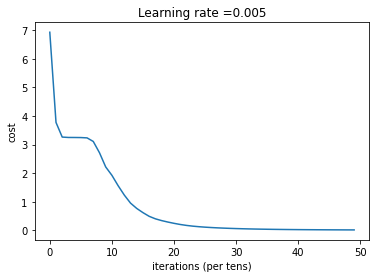

In [110]:
parameters = L_layer_model(X_train, Y_train_, layers_dims, num_iterations = 50000, print_cost = True)

In [111]:
def predict_L_layer(X,parameters):
    AL,caches=L_model_forward(X,parameters)
    prediction=np.argmax(AL,axis=0)

    return prediction.reshape(1,prediction.shape[0])

In [112]:
predictions_train_L = predict_L_layer(X_train, parameters)
print("Training Accuracy : "+ str(np.sum(predictions_train_L==y_train)/y_train.shape[1] * 100)+" %")

Training Accuracy : 100.0 %


In [126]:
print(X_test.shape)
predictions_test_L=predict_L_layer(X_test,parameters)
print("Testing Accuracy : "+ str(np.sum(predictions_test_L==y_test)/y_test.shape[1] * 100)+" %")
print(predictions_test_L.shape)
print(predictions_test_L)

(64, 360)
Testing Accuracy : 97.5 %
(1, 360)
[[2 8 2 6 6 7 1 9 8 5 2 8 6 6 6 6 1 0 5 8 8 7 8 4 7 5 4 9 2 9 4 7 6 8 9 4
  3 1 0 1 8 6 7 7 1 0 7 6 2 1 9 6 7 9 0 0 5 1 6 3 0 2 3 4 1 9 2 6 9 1 8 3
  5 1 2 8 2 2 9 7 2 3 6 0 5 3 7 5 1 2 9 9 3 1 7 7 4 8 5 8 5 5 2 5 9 0 7 1
  4 4 3 4 8 9 7 9 8 3 1 5 2 5 8 4 1 7 0 6 1 5 5 9 9 5 9 9 5 7 5 6 2 8 6 7
  6 1 5 1 5 9 9 1 5 3 6 1 8 9 8 7 6 7 6 5 6 0 8 8 9 8 6 1 0 4 1 6 3 8 6 7
  4 9 6 3 0 3 3 3 0 7 7 5 7 8 0 7 8 9 6 4 5 0 1 4 6 4 3 3 0 9 5 9 2 1 4 2
  1 6 8 9 2 4 9 3 7 6 2 3 3 1 6 9 3 6 3 3 2 0 7 6 1 1 9 7 2 7 8 5 5 7 5 2
  3 7 2 7 5 5 7 0 9 1 6 5 9 7 4 3 8 0 3 6 4 6 3 2 6 8 8 8 4 6 7 5 2 4 5 3
  2 4 6 9 4 5 4 3 4 6 2 9 0 1 7 2 0 9 6 0 4 2 0 7 9 8 5 4 8 2 8 4 3 7 2 6
  9 1 5 1 0 8 2 4 9 5 6 8 2 7 2 1 5 1 6 4 5 0 9 4 1 1 7 0 8 9 0 5 4 3 8 8]]


<Figure size 432x288 with 0 Axes>

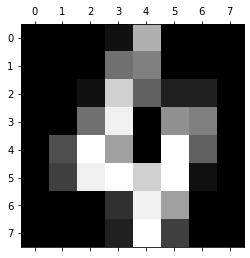

predicted ans:4
actual ans:4


<Figure size 432x288 with 0 Axes>

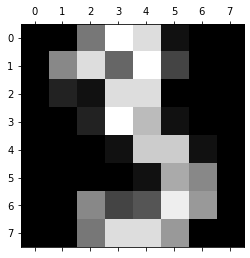

predicted ans:3
actual ans:3


<Figure size 432x288 with 0 Axes>

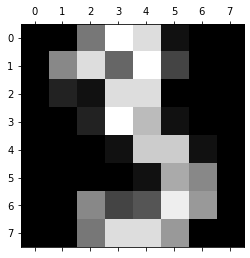

predicted ans:3
actual ans:3


<Figure size 432x288 with 0 Axes>

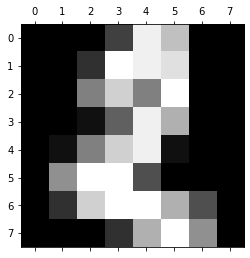

predicted ans:1
actual ans:2


<Figure size 432x288 with 0 Axes>

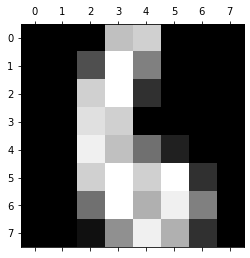

predicted ans:6
actual ans:6


<Figure size 432x288 with 0 Axes>

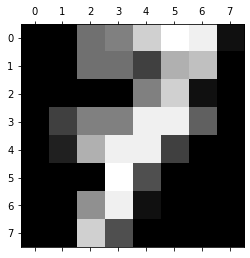

predicted ans:1
actual ans:7


<Figure size 432x288 with 0 Axes>

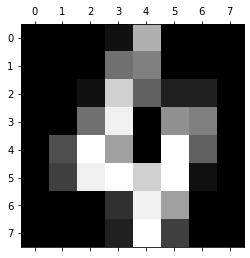

predicted ans:4
actual ans:4


<Figure size 432x288 with 0 Axes>

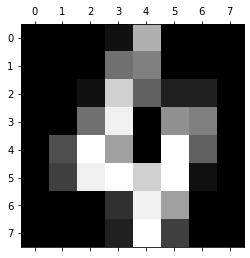

predicted ans:4
actual ans:4


<Figure size 432x288 with 0 Axes>

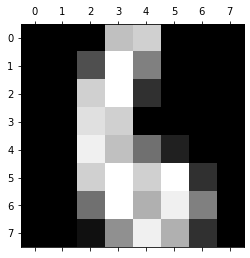

predicted ans:6
actual ans:6


<Figure size 432x288 with 0 Axes>

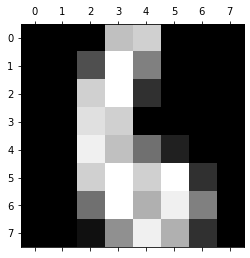

predicted ans:6
actual ans:6


<Figure size 432x288 with 0 Axes>

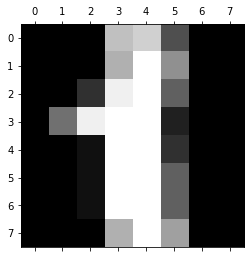

predicted ans:1
actual ans:1


<Figure size 432x288 with 0 Axes>

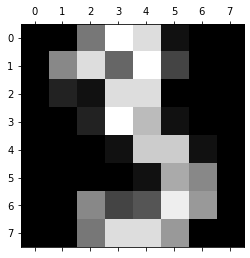

predicted ans:3
actual ans:3


<Figure size 432x288 with 0 Axes>

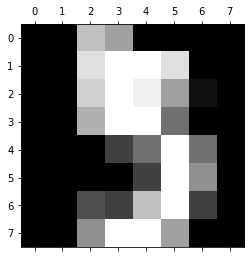

predicted ans:9
actual ans:5


<Figure size 432x288 with 0 Axes>

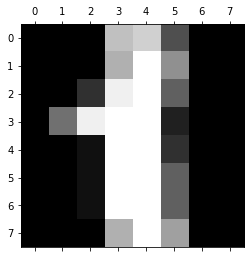

predicted ans:1
actual ans:1


<Figure size 432x288 with 0 Axes>

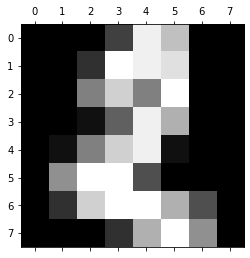

predicted ans:1
actual ans:2


<Figure size 432x288 with 0 Axes>

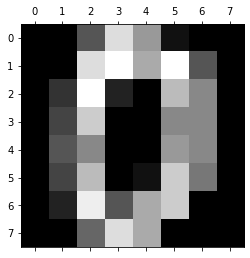

predicted ans:0
actual ans:0


<Figure size 432x288 with 0 Axes>

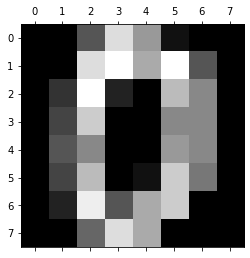

predicted ans:0
actual ans:0


<Figure size 432x288 with 0 Axes>

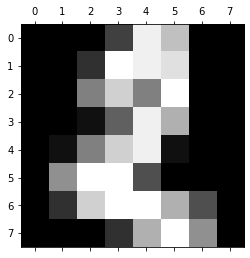

predicted ans:1
actual ans:2


<Figure size 432x288 with 0 Axes>

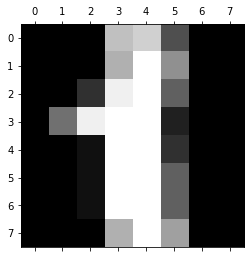

predicted ans:1
actual ans:1


<Figure size 432x288 with 0 Axes>

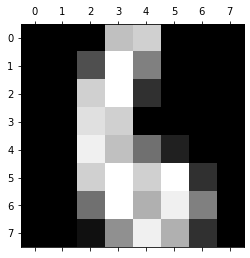

predicted ans:6
actual ans:6


In [165]:
#printing some random predicted result
for j in range(20):
    np.random.seed(2)
    i = random.randint(0,digits.images[0].shape[0])
    pl.gray()
    pl.matshow(digits.images[i])
    pl.show()
    img5 = digits.images[i].reshape((64,1))
    predicted_ans = predict_L_layer(img5,parameters)
    print("predicted ans:"+str(predicted_ans[0][0]))
    print("actual ans:"+str(digits.target[i]))
